In [1]:
import os
import tensorflow as tf
import keras 
import keras.layers as layers
import matplotlib.pyplot as plt
%matplotlib inline

2024-09-26 16:53:20.769042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 16:53:20.781152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 16:53:20.784554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 16:53:20.793515: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 16:53:21.428584: W tensorflow/compiler/tf2

In [2]:
# List available devices
physical_devices = tf.config.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))

if physical_devices:
    try:
        # Restrict TensorFlow to only allocate a small amount of memory on the GPU
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("TensorFlow is using GPU")
    except RuntimeError as e:
        print(e)
else:
    print("TensorFlow is not using GPU")


GPUs Available:  1
TensorFlow is using GPU


I0000 00:00:1727351602.429670   28501 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727351602.446091   28501 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727351602.446135   28501 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
train_dir = os.path.join(os.getcwd(), 'data', 'processed', 'train')
test_dir = os.path.join(os.getcwd(), 'data', 'processed', 'test')
img_size = (300, 600, 1)


In [4]:
train_ds = keras.utils.image_dataset_from_directory(
  train_dir, 
  labels='inferred',
  color_mode='grayscale',
  image_size=(img_size[0], img_size[1]),
)
valid_ds = keras.utils.image_dataset_from_directory(
  test_dir, 
  labels='inferred',
  color_mode='grayscale',
  image_size=(img_size[0], img_size[1]),
)
num_classes = len(train_ds.class_names)
target_names = valid_ds.class_names

# for image_batch, labels_batch in valid_ds:
#   for i in range(len(image_batch)):
#     plt.imshow(image_batch[i].numpy().astype("uint8")[:, :, 0], cmap='gray')
#     plt.title(f"Label: {labels_batch[i].numpy()}")
#     plt.show()

# for image_batch, labels_batch in train_ds:
#   for i in range(len(image_batch)):
#       plt.imshow(image_batch[i].numpy().astype("uint8")[:, :, 0], cmap='gray')
#       plt.title(f"Label: {labels_batch[i].numpy()}")
#       plt.show()


Found 552 files belonging to 184 classes.


I0000 00:00:1727351602.958713   28501 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727351602.958778   28501 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727351602.958792   28501 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727351603.089562   28501 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727351603.089622   28501 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-26

Found 184 files belonging to 184 classes.


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
normalization_layer = keras.layers.Rescaling(1./255)

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=img_size),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Lambda(lambda x: 1 - x) 

  ]
)

model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax', name="outputs")
])

/home/wahab/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 300, 600, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 300, 600, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 300, 600, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 300, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 300, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 150, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 150, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 177600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    22,732,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 184)            │        23,736 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,779,960 (86.90 MB)

 Trainable params: 22,779,960 (86.90 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/10


/home/wahab/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-09-26 16:53:25.435447: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-09-26 16:53:26.317787: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1727351606.364146   28607 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351606.379688   28607 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:17273

 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.0000e+00 - loss: 6.0409

W0000 00:00:1727351612.210475   28607 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351612.235822   28607 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0013 - loss: 6.0696 

W0000 00:00:1727351613.525580   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351613.527466   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351613.529120   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351613.530874   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351613.532676   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351613.534782   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351613.536634   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351613.539891   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351613.542552   28608 gp

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.0013 - loss: 6.0440

W0000 00:00:1727351614.986908   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351614.989192   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351614.995045   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.008859   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.013721   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.015741   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.018031   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.020404   28608 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.023932   28608 gp

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.0016 - loss: 5.9973

W0000 00:00:1727351615.726072   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.728873   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.731509   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.734240   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.738072   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.740826   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.743546   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.749337   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351615.755111   28606 gp

18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - accuracy: 0.0017 - loss: 5.9770 - val_accuracy: 0.0054 - val_loss: 5.2187
Epoch 2/10


W0000 00:00:1727351616.549658   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351616.553111   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351616.555813   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351616.559625   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351616.562548   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351616.565718   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351616.568680   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351616.571503   28606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727351616.574325   28606 gp

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.0076 - loss: 5.2219 - val_accuracy: 0.0054 - val_loss: 5.2147
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.0014 - loss: 5.2155 - val_accuracy: 0.0054 - val_loss: 5.2129
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.0063 - loss: 5.2153 - val_accuracy: 0.0109 - val_loss: 5.2110
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.0191 - loss: 5.2130 - val_accuracy: 0.0054 - val_loss: 5.2022
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.0122 - loss: 5.1994 - val_accuracy: 0.0109 - val_loss: 5.1335
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.0150 - loss: 5.1270 - val_accuracy: 0.0163 - val_loss: 4.9894
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.0396 - loss: 4.9612 - val_accuracy: 0.0380 - val_loss: 4.8766
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.0533 - loss: 4.6708 - val_accuracy: 0.0598 - val_loss: 4.

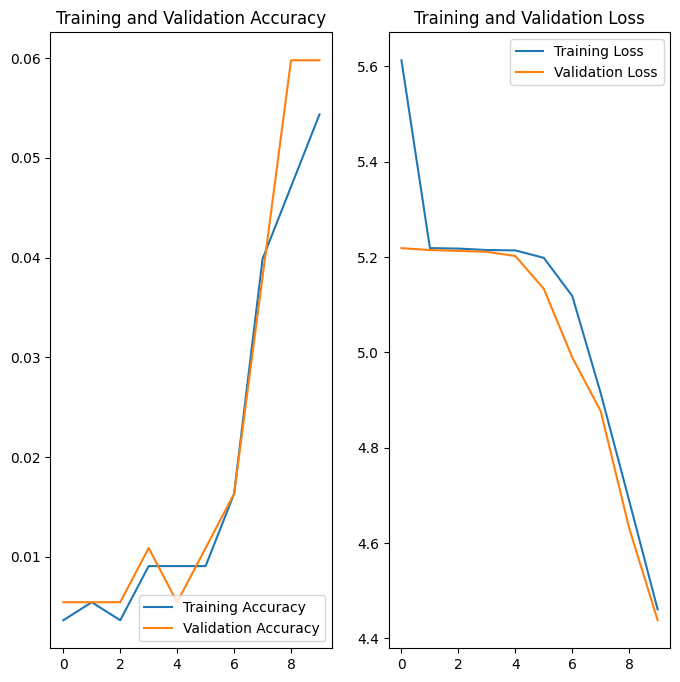

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
import numpy as np

# Get predictions on the validation set
y_pred_prob = model.predict(valid_ds)  # Predict class probabilities
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()  # Convert probabilities to class labels

y_true = []
for images, labels in valid_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)  # Convert the list to a numpy array


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


2024-09-26 16:53:51.599357: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


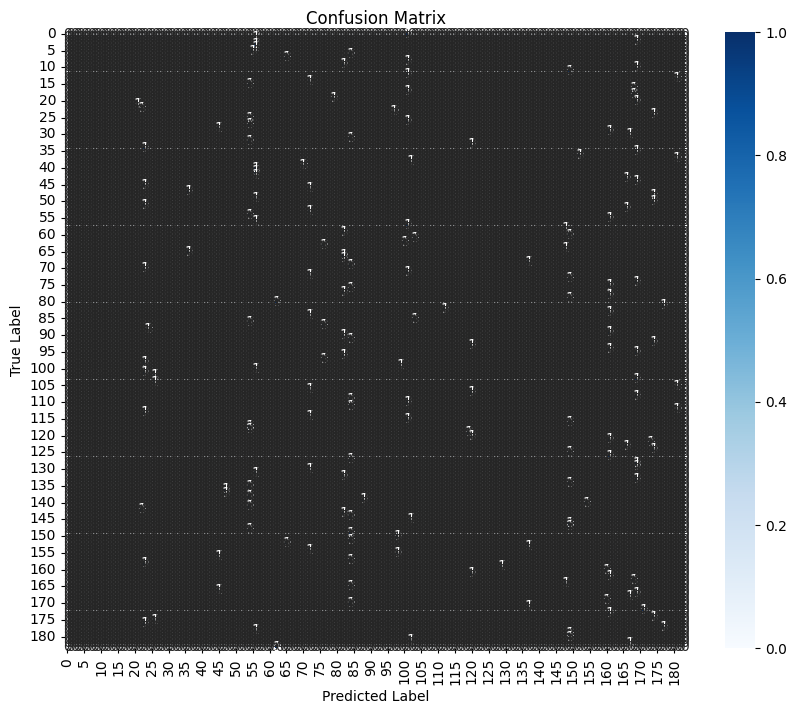

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# # Create a confusion matrix
# cm = confusion_matrix(y_true, y_pred)


# # Visualize the confusion matrix using seaborn's heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

In [14]:
from sklearn.metrics import classification_report, accuracy_score

# Classification report for precision, recall, and F1-score
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

# Accuracy score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
         100       0.00      0.00      0.00         1
         101       0.00      0.00      0.00         1
         102       0.00      0.00      0.00         1
         103       0.00      0.00      0.00         1
         104       0.00      0.00      0.00         1
         105       0.00      0.00      0.00         1
         106       0.00      0.00      0.00         1
         107       0.00      0.00      0.00         1
         108       0.00      0.00      0.00         1
         109       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
         110       0.00      0.00      0.00         1
         111       0.00      0.00      0.00         1
         112       0.00      0.00      0.00         1
         113       0.00      0.00      0.00         1
         114       0.00    

/home/wahab/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wahab/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wahab/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
base_model = tf.keras.applications.ResNet50(input_shape=(300, 600, 3),include_top=False,weights='imagenet')

base_model.trainable = False  # Freeze the base model layers
model = keras.Sequential([
    layers.InputLayer(input_shape=(300, 600, 1)),  # Original input shape
    layers.Conv2D(3, (3, 3), padding='same', activation='relu'),  # Convert grayscale to RGB
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Replace num_classes with the actual number of classes
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 300, 600, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 10, 19, 2048)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 184)            │        23,736 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,873,750 (91.07 MB)

 Trainable params: 286,038 (1.09 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/15


I0000 00:00:1727352212.976639   28607 service.cc:146] XLA service 0x7faa65792af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727352212.976671   28607 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-09-26 17:03:33.101546: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-26 17:03:34.791091: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5766', 168 bytes spill stores, 452 bytes spill loads

2024-09-26 17:03:35.956217: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8800', 36 bytes spill stores, 40 bytes spill loads

2024-09-26 17:03:36.084179: I external/loca

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.0041 - loss: 5.3793

2024-09-26 17:04:15.701237: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1708', 12 bytes spill stores, 12 bytes spill loads

2024-09-26 17:04:15.755732: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1708', 176 bytes spill stores, 176 bytes spill loads



18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.0043 - loss: 5.3761 - val_accuracy: 0.0109 - val_loss: 5.1341
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 359ms/step - accuracy: 0.0114 - loss: 5.1456 - val_accuracy: 0.0163 - val_loss: 5.0183
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.0205 - loss: 4.9592 - val_accuracy: 0.0598 - val_loss: 4.8629
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step - accuracy: 0.0606 - loss: 4.7557 - val_accuracy: 0.0598 - val_loss: 4.6779
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 361ms/step - accuracy: 0.0839 - loss: 4.5242 - val_accuracy: 0.0815 - val_loss: 4.4578
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - accuracy: 0.1540 - loss: 4.1862 - val_accuracy: 0.1304 - val_loss: 4.0906
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 360ms/step - accuracy: 0.1909 - loss: 3.8553 - val_accuracy: 0.2174 - val_loss: 3.7331
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 360ms/step - accuracy: 0.2821 - loss: 3.4563 - val_accuracy: 0.2989 - val_lo

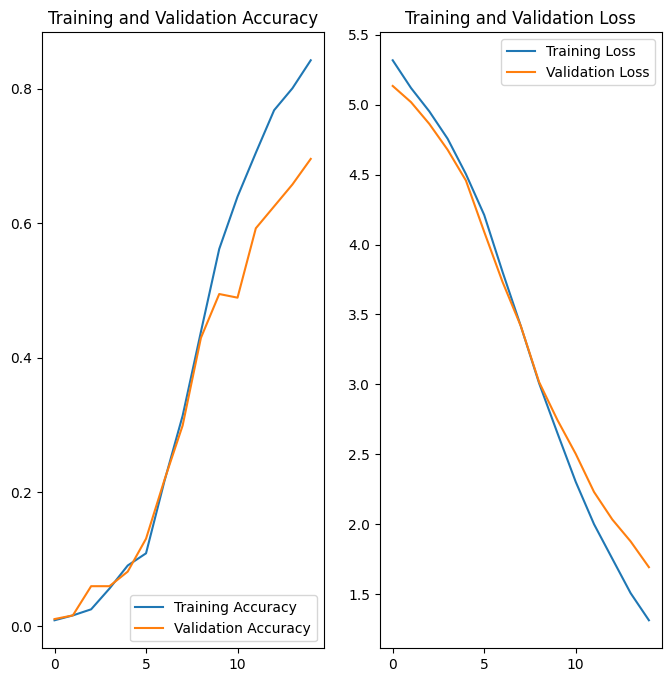

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
import numpy as np

# Get predictions on the validation set
y_pred_prob = model.predict(valid_ds)  # Predict class probabilities
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()  # Convert probabilities to class labels

y_true = []
for images, labels in valid_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)  # Convert the list to a numpy array


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 519ms/step


2024-09-26 17:07:52.434003: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


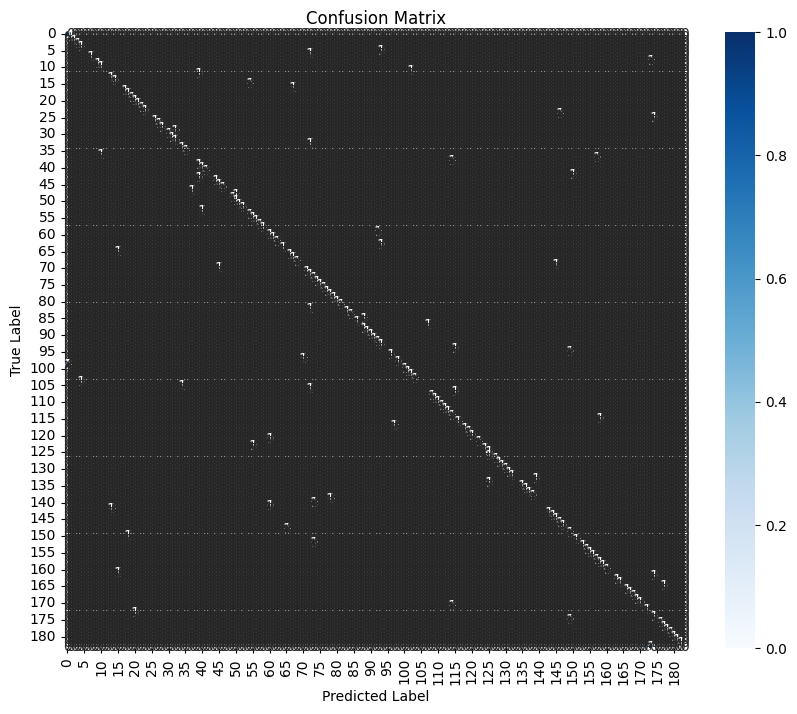

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()